In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35861 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_param_2.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_param_kpp3', '025deg_jra55_ryf_nostress_param_kpp']
name = ['Control', 'No-stress']

In [4]:
start_time = '1990-01-01'
end_time = '1999-12-31'

g = 9.81
rho0 = 1026

## Heat fluxes

In [5]:
heat_sfc_cont = cc.querying.getvar(expt = expt[0], session = session, variable = 'net_sfc_heating', frequency = '1 monthly')
heat_sfc_pram = cc.querying.getvar(expt = expt[1], session = session, variable = 'net_sfc_heating', frequency = '1 monthly')

Text(0.5, 1.0, 'Surface heat flux for nostress run - January')

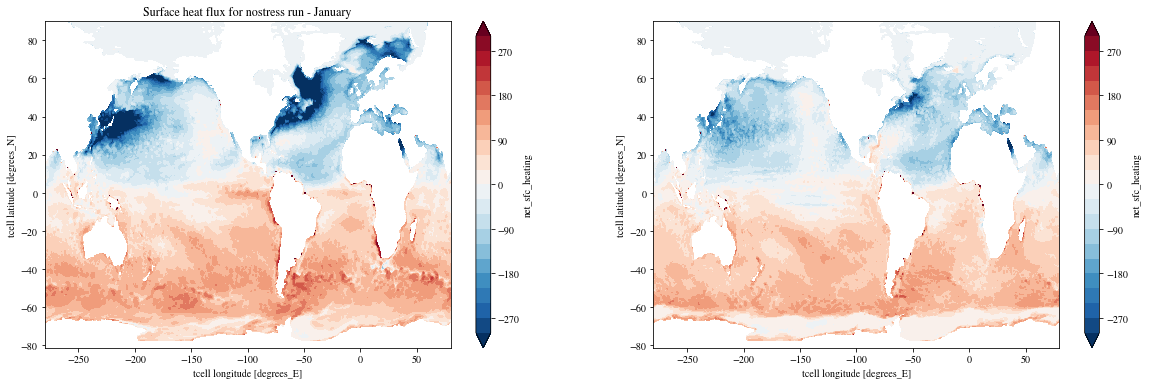

In [6]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice('1999-01-01', '1999-01-31')).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-300, 300, 21))
axes[0].set_title('Surface heat flux for control run - January')

heat_sfc_pram.sel(time = slice('1999-01-01', '1999-01-31')).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-300, 300, 21))
axes[0].set_title('Surface heat flux for nostress run - January')

Text(0.5, 1.0, 'Surface heat flux for nostress run - July')

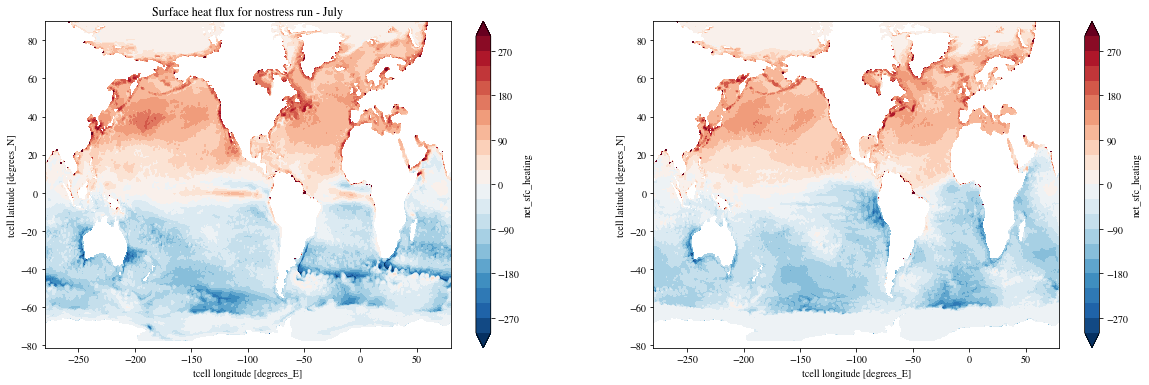

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice('1999-07-01', '1999-07-31')).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-300, 300, 21))
axes[0].set_title('Surface heat flux for control run - July')

heat_sfc_pram.sel(time = slice('1999-07-01', '1999-07-31')).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-300, 300, 21))
axes[0].set_title('Surface heat flux for nostress run - July')

In [8]:
hblt_cont = cc.querying.getvar(expt = expt[0], session = session, variable = 'hblt', frequency = '1 monthly')
hblt_pram = cc.querying.getvar(expt = expt[1], session = session, variable = 'hblt', frequency = '1 monthly')

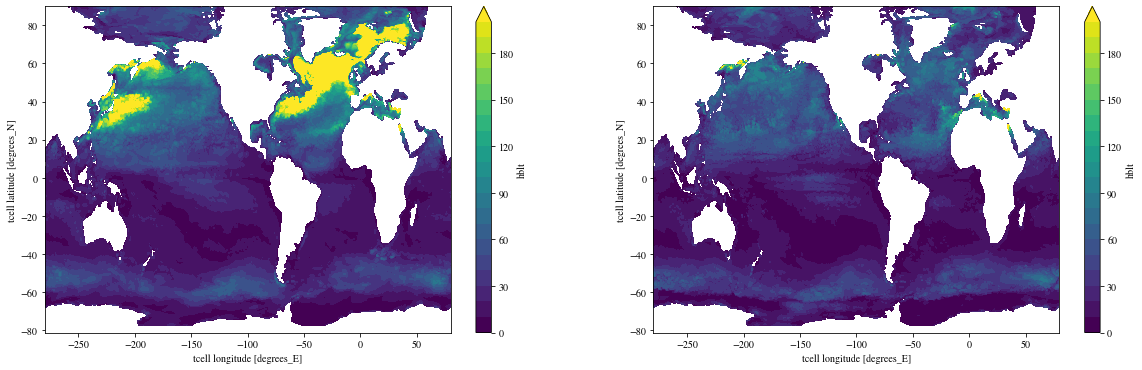

In [9]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice('1999-01-01', '1999-01-31')).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(0, 200, 21))
hblt_pram.sel(time = slice('1999-01-01', '1999-01-31')).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(0, 200, 21))

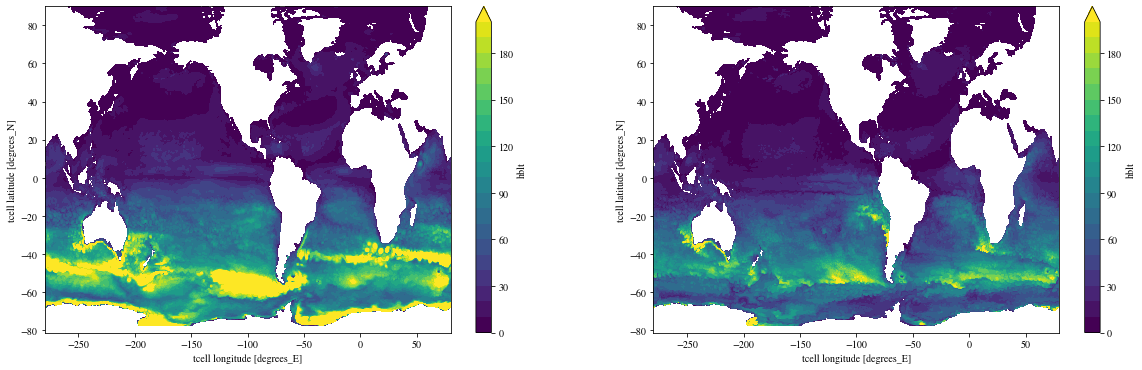

In [10]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice('1999-07-01', '1999-07-31')).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(0, 200, 21))
hblt_pram.sel(time = slice('1999-07-01', '1999-07-31')).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(0, 200, 21))

In [11]:
z_t = cc.querying.getvar(expt[0],'st_ocean',session,n=1)
y_t = cc.querying.getvar(expt[0],'yt_ocean',session, n=1)
x_t = cc.querying.getvar(expt[0],'xt_ocean',session, n=1)

temp_cont = cc.querying.getvar(expt[0], 'temp', session, frequency = '1 monthly', start_time='1990-01-01', end_time='1999-12-31').sel(time=slice('1990-01-01','1999-12-31'))
salt_cont = cc.querying.getvar(expt[0], 'salt', session, frequency = '1 monthly', start_time='1990-01-01', end_time='1999-12-31').sel(time=slice('1990-01-01','1999-12-31'))

temp_pram = cc.querying.getvar(expt[1], 'temp', session, frequency = '1 monthly', start_time='1990-01-01', end_time='1999-12-31').sel(time=slice('1990-01-01','1999-12-31'))
salt_pram = cc.querying.getvar(expt[1], 'salt', session, frequency = '1 monthly', start_time='1990-01-01', end_time='1999-12-31').sel(time=slice('1990-01-01','1999-12-31'))

Y,Z,X = np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})

In [12]:
rho_cont = rho(salt_cont, temp_cont-273.15, pressure_array).sel(st_ocean = slice(0, 2000)).mean('st_ocean')
rho_pram = rho(salt_pram, temp_pram-273.15, pressure_array).sel(st_ocean = slice(0, 2000)).mean('st_ocean')

dbdy_cont = (g*(rho0 - rho_cont)/rho0).differentiate('yt_ocean')
dbdy_pram = (g*(rho0 - rho_pram)/rho0).differentiate('yt_ocean')

dbdy_cont = dbdy_cont.where(abs(dbdy_cont <= 1e-2))
dbdy_pram = dbdy_pram.where(abs(dbdy_pram <= 1e-2))

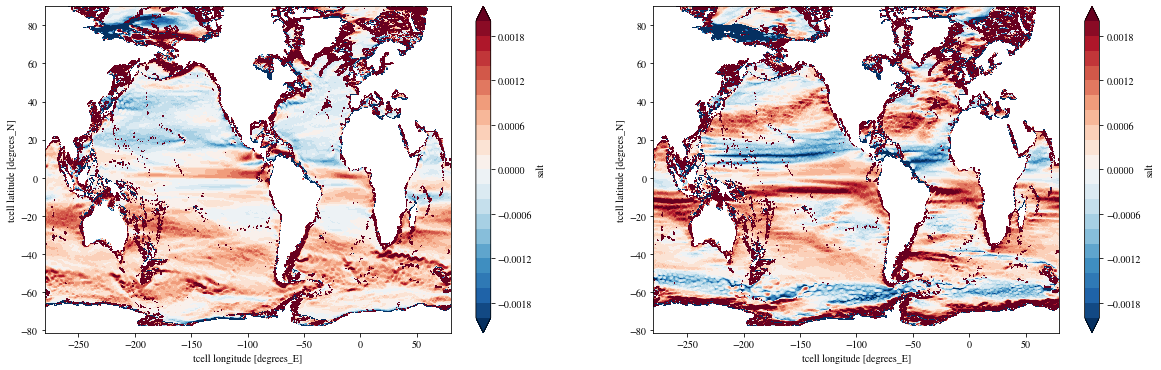

In [13]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

dbdy_cont.mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-2e-3, 2e-3, 21))
dbdy_pram.mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-2e-3, 2e-3, 21))

## Gyre

In [14]:
start_time = '1990-01-01'
end_time = '1999-12-31'

tx_trans_int_z_cont = cc.querying.getvar(expt[0], 'tx_trans_int_z', session, start_time = start_time, end_time = end_time)
ty_trans_int_z_cont = cc.querying.getvar(expt[0], 'ty_trans_int_z', session, start_time = start_time, end_time = end_time)
tx_trans_int_z_pram = cc.querying.getvar(expt[1], 'tx_trans_int_z', session, start_time = start_time, end_time = end_time)
ty_trans_int_z_pram = cc.querying.getvar(expt[1], 'ty_trans_int_z', session, start_time = start_time, end_time = end_time)

In [15]:
rho0 = 1025

x_min, x_max = -100, 10
y_min, y_max = 10, 75
ty_cont_NA = ty_trans_int_z_cont.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_cont_NA = ty_cont_NA.cumsum('xt_ocean').where(abs(ty_cont_NA<=1.e20))/(rho0*1.e6)
ty_pram_NA = ty_trans_int_z_pram.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_pram_NA = ty_pram_NA.cumsum('xt_ocean').where(abs(ty_pram_NA<=1.e20))/(rho0*1.e6)

x_min, x_max = -250, -100
y_min, y_max = 10, 75
ty_cont_NP = ty_trans_int_z_cont.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_cont_NP = ty_cont_NP.cumsum('xt_ocean').where(abs(ty_cont_NP<=1.e20))/(rho0*1.e6)
ty_pram_NP = ty_trans_int_z_pram.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_pram_NP = ty_pram_NP.cumsum('xt_ocean').where(abs(ty_pram_NP<=1.e20))/(rho0*1.e6)

x_min, x_max = -70, 20
y_min, y_max = -80, -55
tx_cont_SA = tx_trans_int_z_cont.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psi_cont_SA = tx_cont_SA.cumsum('yt_ocean').where(abs(tx_cont_SA<=1.e20))/(rho0*1.e6)
tx_pram_SA = tx_trans_int_z_pram.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psi_pram_SA = tx_pram_SA.cumsum('yt_ocean').where(abs(tx_pram_SA<=1.e20))/(rho0*1.e6)

x_min, x_max = -220, -100
y_min, y_max = -80, -60
tx_cont_SP = tx_trans_int_z_cont.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psi_cont_SP = -tx_cont_SP.cumsum('yt_ocean').where(abs(tx_cont_SP<=1.e20))/(rho0*1.e6)
tx_pram_SP = tx_trans_int_z_pram.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psi_pram_SP = -tx_pram_SP.cumsum('yt_ocean').where(abs(tx_pram_SP<=1.e20))/(rho0*1.e6)

Text(0.5, 1.0, 'Barotropic Streamfunction (SP) - Nostress Run')

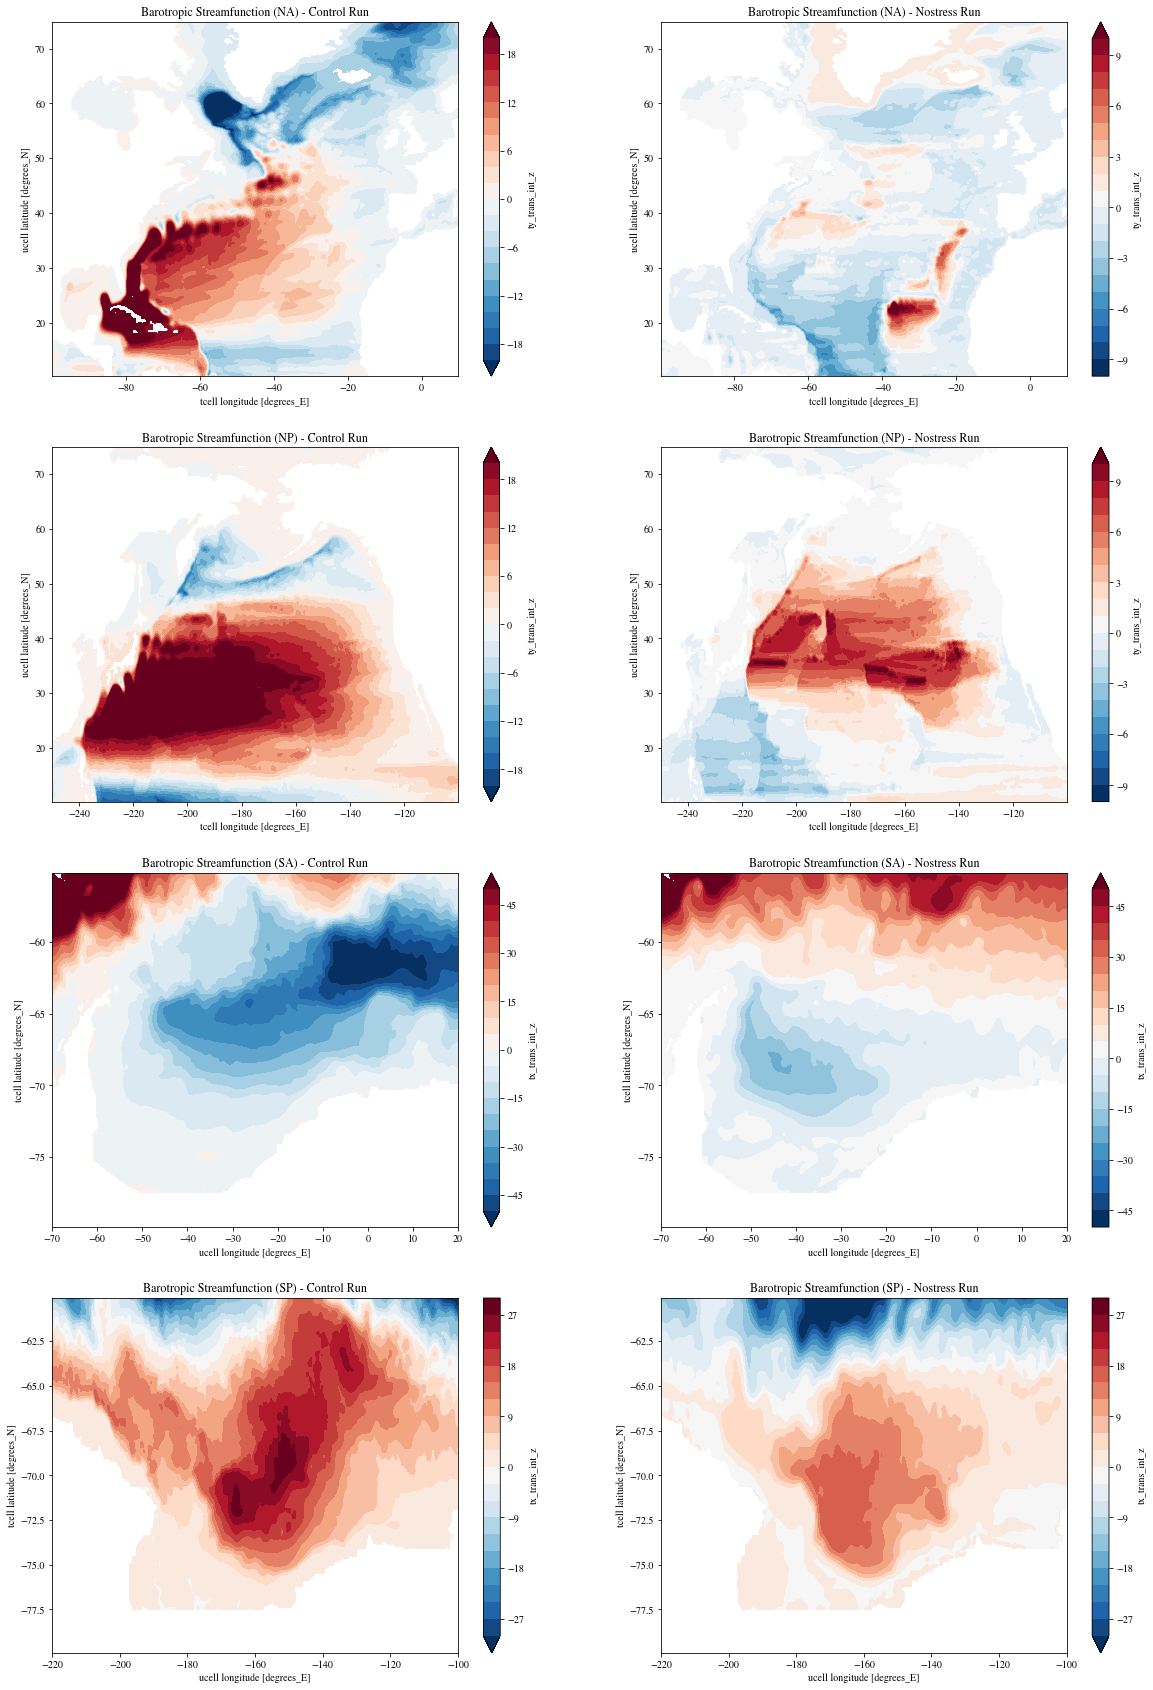

In [16]:
start_time_gyre = '1990-01-01'
end_time_gyre = '1999-12-31'
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,30))

psi_cont_NA.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[0][0], levels = np.linspace(-20,20,21))
axes[0][0].set_title('Barotropic Streamfunction (NA) - Control Run')

psi_pram_NA.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[0][1], levels = np.linspace(-10,10,21))
axes[0][1].set_title('Barotropic Streamfunction (NA) - Nostress Run')

psi_cont_NP.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[1][0], levels = np.linspace(-20,20,21))
axes[1][0].set_title('Barotropic Streamfunction (NP) - Control Run')

psi_pram_NP.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[1][1], levels = np.linspace(-10,10,21))
axes[1][1].set_title('Barotropic Streamfunction (NP) - Nostress Run')

psi_cont_SA.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[2][0], levels = np.linspace(-50,50,21))
axes[2][0].set_title('Barotropic Streamfunction (SA) - Control Run')

psi_pram_SA.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[2][1], levels = np.linspace(-50,50,21))
axes[2][1].set_title('Barotropic Streamfunction (SA) - Nostress Run')

psi_cont_SP.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[3][0], levels = np.linspace(-30,30,21))
axes[3][0].set_title('Barotropic Streamfunction (SP) - Control Run')

psi_pram_SP.sel(time = slice(start_time_gyre, end_time_gyre)).mean('time').plot.contourf(ax = axes[3][1], levels = np.linspace(-30,30,21))
axes[3][1].set_title('Barotropic Streamfunction (SP) - Nostress Run')

## 1. North Pacific 

Text(0.5, 1.0, 'Barotropic Streamfunction (NP) - Nostress Run')

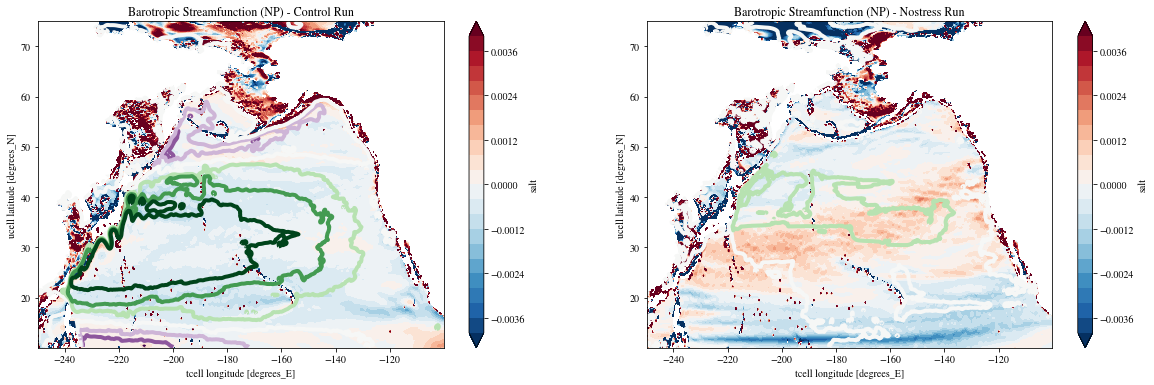

In [17]:
x_min, x_max = -250, -100
y_min, y_max = 10, 75

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

dbdy_cont.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).sel(
    time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-4e-3, 4e-3, 21))
psi_cont_NP.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[0], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-20,20,7))
axes[0].set_title('Barotropic Streamfunction (NP) - Control Run')

dbdy_pram.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).sel(
    time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-4e-3, 4e-3, 21))
psi_pram_NP.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[1], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-20,20,7))
axes[1].set_title('Barotropic Streamfunction (NP) - Nostress Run')

There is a subtropical gyre in the North Pacific in the no-stress run. It takes a U-turn near longitude 200 W, because of a seamount, which decreases the ocean depth to about 2 km. The control run doesn't suffer from this issue, since it is wind-driven and the circulation is confined to the upper 1-2 km. Now, a good question is whether this is due to PV homogenisation, or this is due to buoyancy flux?

Similarly, there is a cyclonic gyre in the tropical regions too. Negative db/dy results in positive meridional transport, and vice-versa. The sign also depends upon the direction of heat flux entering into the ocean. 

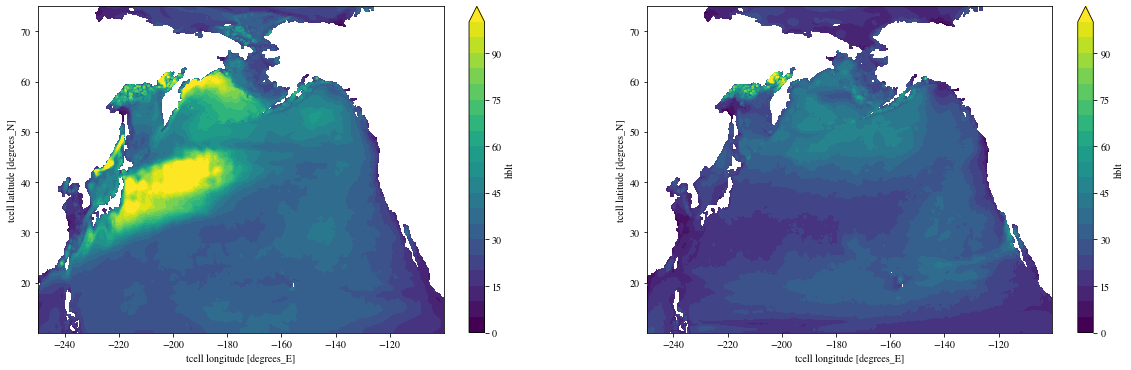

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(0, 100, 21))
hblt_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(0, 100, 21))

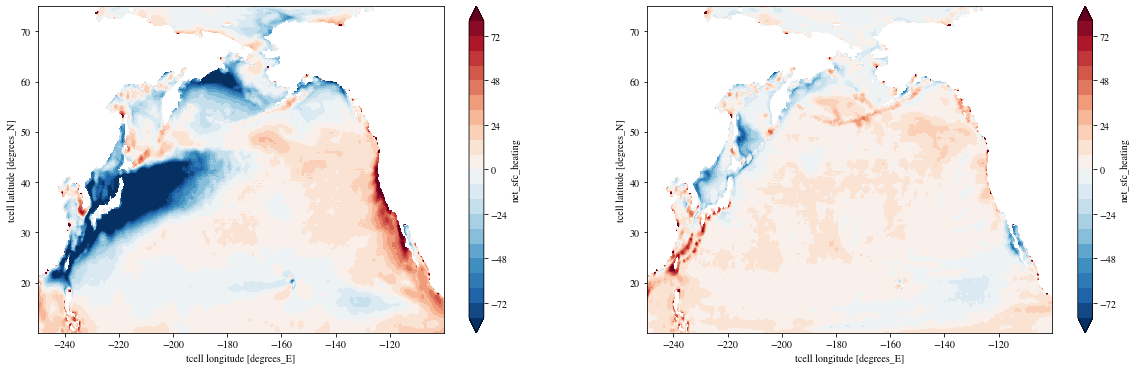

In [19]:
x_min = -250
x_max = -100
y_min = 10
y_max = 75

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(-80, 80, 21))
heat_sfc_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(-80, 80, 21))

1. According to the results, the Pacific ocean gyre in the control run should be 2.625 times stronger than the no-stress run.

## 2. North Atlantic

Text(0.5, 1.0, 'Barotropic Streamfunction (NA) - No-stress Run')

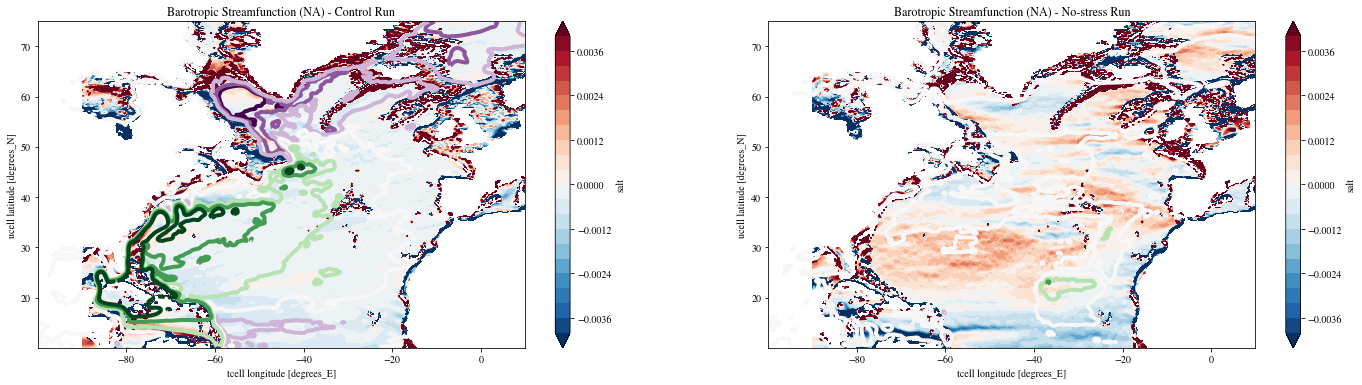

In [20]:
x_min, x_max = -90, 10
y_min, y_max = 10, 75

fig, axes = plt.subplots(ncols = 2, figsize = (24,6))

dbdy_cont.sel(xt_ocean = slice(x_min, x_max)).sel(time = slice(start_time, end_time)).sel(
    yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-4e-3, 4e-3, 21))
psi_cont_NA.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[0], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-20,20,7))
axes[0].set_title('Barotropic Streamfunction (NA) - Control Run')

dbdy_pram.sel(xt_ocean = slice(x_min, x_max)).sel(time = slice(start_time, end_time)).sel(
    yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-4e-3, 4e-3, 21))
psi_pram_NA.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[1], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-20,20,7))
axes[1].set_title('Barotropic Streamfunction (NA) - No-stress Run')

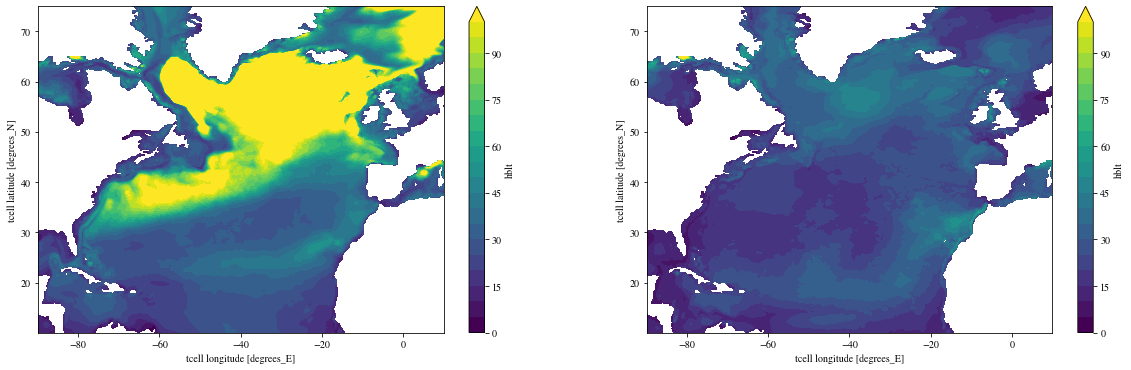

In [21]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(0, 100, 21))
hblt_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(0, 100, 21))

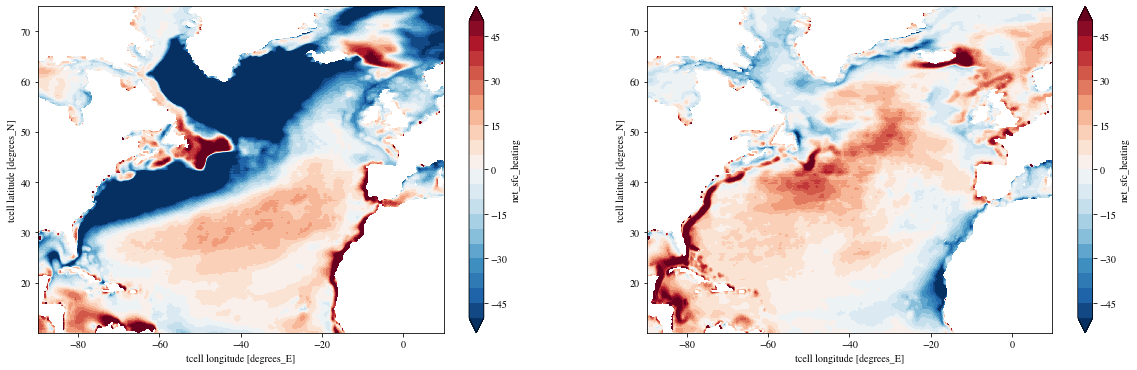

In [22]:
x_min, x_max = -90, 10
y_min, y_max = 10, 75

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(-50, 50, 21))
heat_sfc_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(-50, 50, 21))

North Atlantic gyre - 133.33 times stronger than nostress run

## Weddell Gyre

Text(0.5, 1.0, 'Barotropic Streamfunction (NP) - No-stress Run')

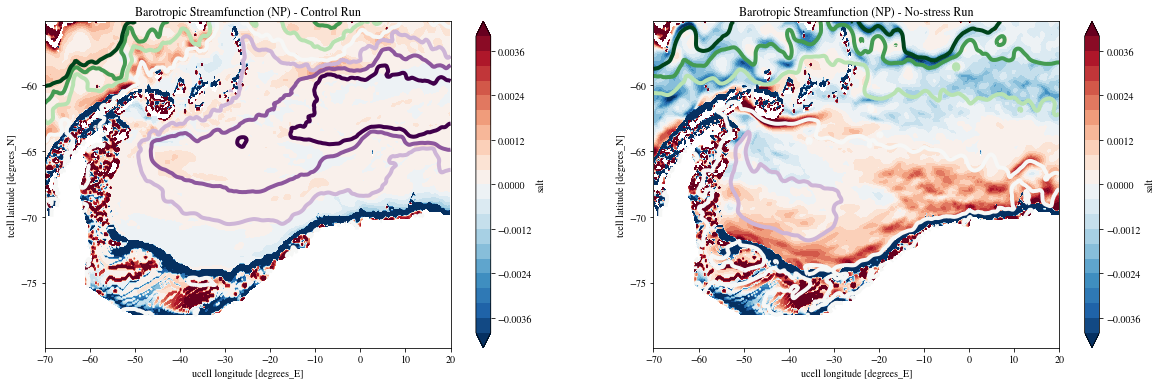

In [29]:
x_min, x_max = -70, 20
y_min, y_max = -80, -55

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

dbdy_cont.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).sel(
time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-4e-3, 4e-3, 21))
psi_cont_SA.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[0], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-40,40,7))
axes[0].set_title('Barotropic Streamfunction (SA) - Control Run')

dbdy_pram.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).sel(
time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-4e-3, 4e-3, 21))
psi_pram_SA.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[1], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-40,40,7))
axes[1].set_title('Barotropic Streamfunction (SA) - No-stress Run')

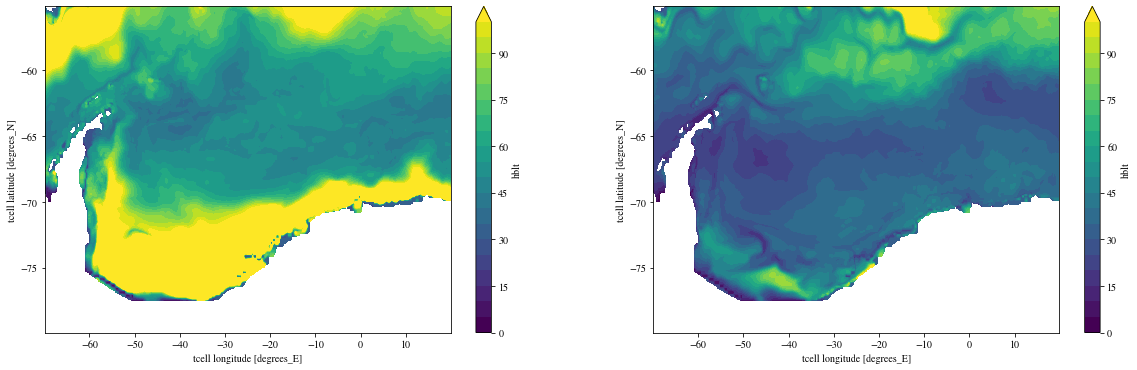

In [24]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(0, 100, 21))
hblt_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(0, 100, 21))

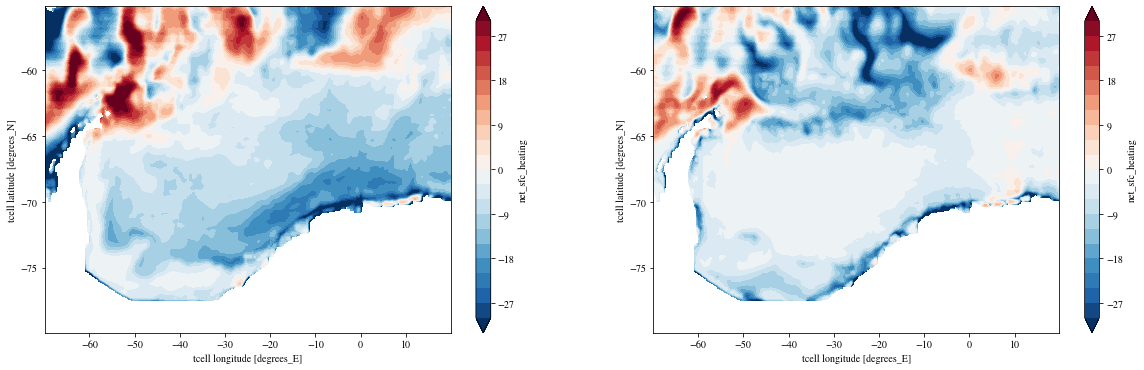

In [25]:
x_min, x_max = -70, 20
y_min, y_max = -80, -55

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(-30, 30, 21))
heat_sfc_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(-30, 30, 21))

## Ross Gyre

Text(0.5, 1.0, 'Barotropic Streamfunction (SP) - Control Run')

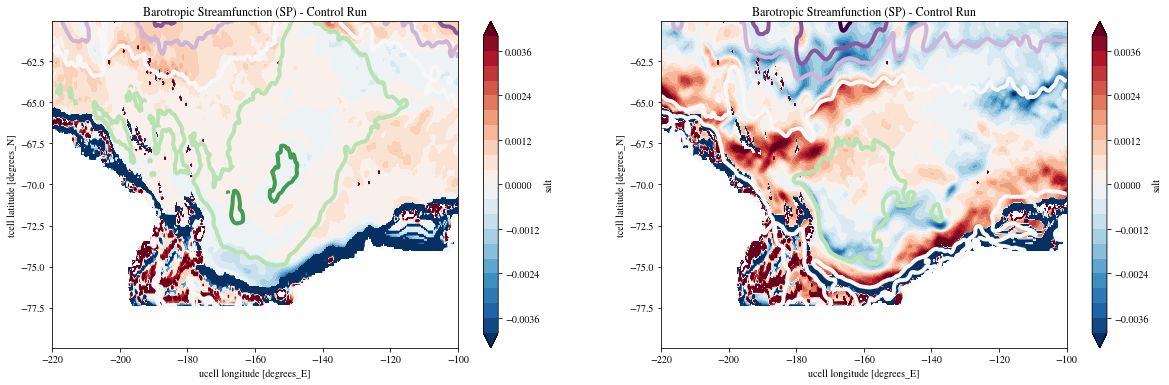

In [32]:
x_min, x_max = -220, -100
y_min, y_max = -80, -60

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

dbdy_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(
    yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(ax = axes[0], levels = np.linspace(-4e-3, 4e-3, 21))
psi_cont_SP.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[0], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-40,40,7))
axes[0].set_title('Barotropic Streamfunction (SP) - Control Run')

dbdy_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(
    yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(ax = axes[1], levels = np.linspace(-4e-3, 4e-3, 21))
psi_pram_SP.sel(time = slice(start_time, end_time)).mean('time').plot.contour(ax = axes[1], cmap = 'PRGn', linewidths = 4, levels = np.linspace(-40,40,7))
axes[1].set_title('Barotropic Streamfunction (SP) - Control Run')

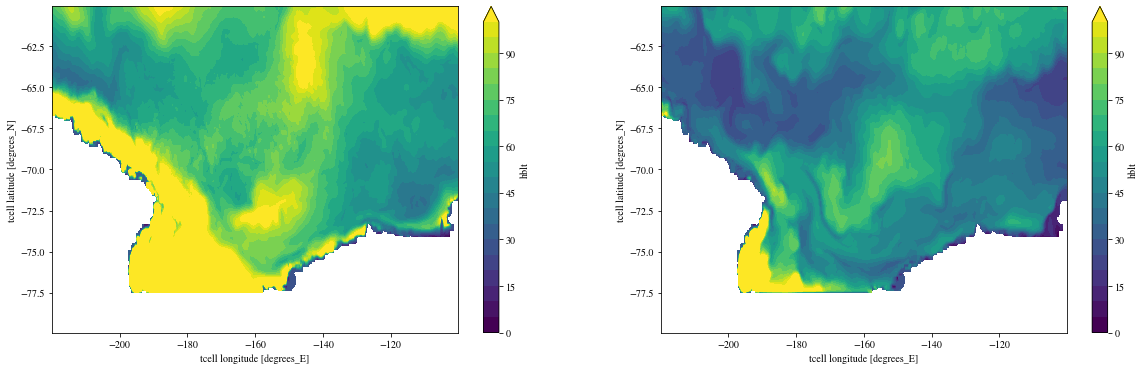

In [27]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

hblt_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(0, 100, 21))
hblt_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(0, 100, 21))

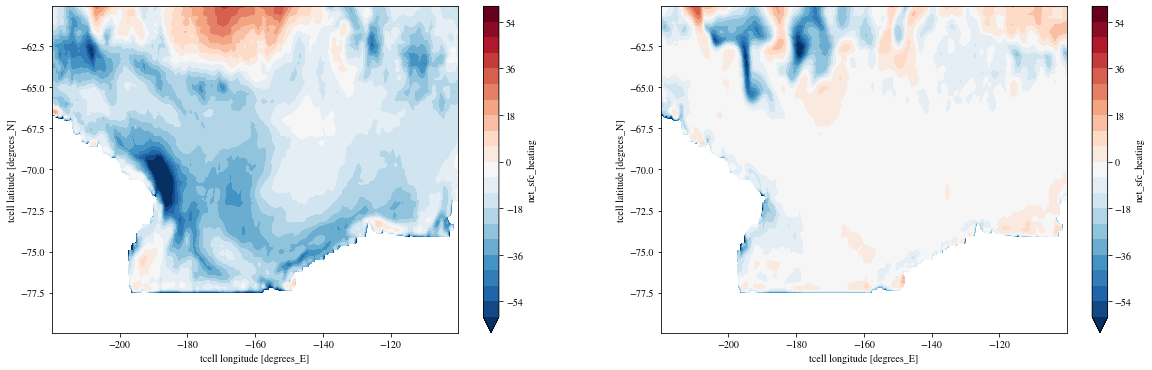

In [28]:
x_min, x_max = -220, -100
y_min, y_max = -80, -60

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

heat_sfc_cont.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[0], levels = np.linspace(-60, 60, 21))
heat_sfc_pram.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time').plot.contourf(
    ax = axes[1], levels = np.linspace(-60, 60, 21))